In [1]:
import pandas as pd
import commons as me

knownLos = pd.read_csv('../data/clean/known_los.csv')
len(knownLos)

73

In [2]:
# Removing LOS where I could not pinpoint the observer or target location

knownLos = knownLos.dropna(subset=['from_latitude', 'from_longitude', 'to_latitude', 'to_longitude'])
knownLos['curvature'] = None

len(knownLos)

46

In [3]:
# Removing LOS where the reported distance does not match the actual distance based on identifications

def getKnownLosDistance(los):
    return me.geod.line_length([los.from_longitude, los.to_longitude], [los.from_latitude, los.to_latitude])

knownLos['distance_reported'] = knownLos.distance
knownLos['distance_true'] = round(knownLos.apply(getKnownLosDistance, axis=1)/1000, 3) # in km
knownLos = knownLos.query('abs(distance_true - distance) < 1')

len(knownLos)

34

In [4]:
# Finding the minimum light curvature needed for all known LOS to be possible

testCurvature = 7.7 # Max light curvature to test

while sum(knownLos.curvature.isna()) > 0 and testCurvature >= 1.0: # testCurvature = 1 gives the best LOS conditions

    print(f'Test Curvature: {round(testCurvature, 1)}')
    print(f'LOS Remaining: {sum(knownLos.curvature.isna())}\n')

    missingCurvatureMask = knownLos.curvature.isna()

    for i in knownLos.index[missingCurvatureMask]:
        los = knownLos.loc[i]
    
        observer = me.Summit(latitude=los.from_latitude,
                             longitude=los.from_longitude,
                             elevation=los.from_elevation)

        target = me.Summit(latitude=los.to_latitude,
                           longitude=los.to_longitude,
                           elevation=los.to_elevation)
    
        lineOfSight = me.LineOfSight(observer, target, lightCurvature=testCurvature)
        lineOfSight.processFullLineOfSight()
    
        if not lineOfSight.isObstructed():
            knownLos.at[i, 'curvature'] = round(testCurvature, 1)
    
    allCurvaturesFound = knownLos.curvature.notna().all()
    
    testCurvature -= 0.1

Test Curvature: 7.7
LOS Remaining: 34

Test Curvature: 7.6
LOS Remaining: 2

Test Curvature: 7.5
LOS Remaining: 2

Test Curvature: 7.4
LOS Remaining: 2

Test Curvature: 7.3
LOS Remaining: 2

Test Curvature: 7.2
LOS Remaining: 2

Test Curvature: 7.1
LOS Remaining: 2

Test Curvature: 7.0
LOS Remaining: 2

Test Curvature: 6.9
LOS Remaining: 2

Test Curvature: 6.8
LOS Remaining: 1

Test Curvature: 6.7
LOS Remaining: 1

Test Curvature: 6.6
LOS Remaining: 1

Test Curvature: 6.5
LOS Remaining: 1

Test Curvature: 6.4
LOS Remaining: 1



In [5]:
knownLos = knownLos[['from', 'from_area', 'from_elevation', 'from_latitude', 'from_longitude', 
                     'to', 'to_area', 'to_elevation', 'to_latitude', 'to_longitude', 
                     'distance_reported', 'distance_true', 'curvature']]

knownLos.head()

,from,from_area,from_elevation,from_latitude,from_longitude,to,to_area,to_elevation,to_latitude,to_longitude,distance_reported,distance_true,curvature
0,Finestrelles,Pirineos E (ES),2827,42.414475,2.133279,Pic Gaspard,Alpes (FR),3883,44.99811,6.33042,443,443.011,6.9
1,Bastiments,Pirineos E (ES),2881,42.426120,2.233078,Doigt de Dieu,Alpes (FR),3973,45.00382,6.31445,436,435.503,7.7
2,Bastiments,Pirineos E (ES),2881,42.426120,2.233078,Barre des Ecrins,Alpes (FR),4102,44.92215,6.35953,432,432.529,7.7
3,Canigou,Pirineos E (FR),2784,42.518976,2.456582,Pic Gaspard,Alpes (FR),3867,44.99811,6.33042,416,415.584,7.7
4,Canigou,Pirineos E (FR),2784,42.518976,2.456582,Barre des Ecrins,Alpes (FR),4102,44.92215,6.35953,412,411.961,7.7


In [6]:
knownLos.to_csv('../data/clean/known_los_with_curvature.csv', index=False)

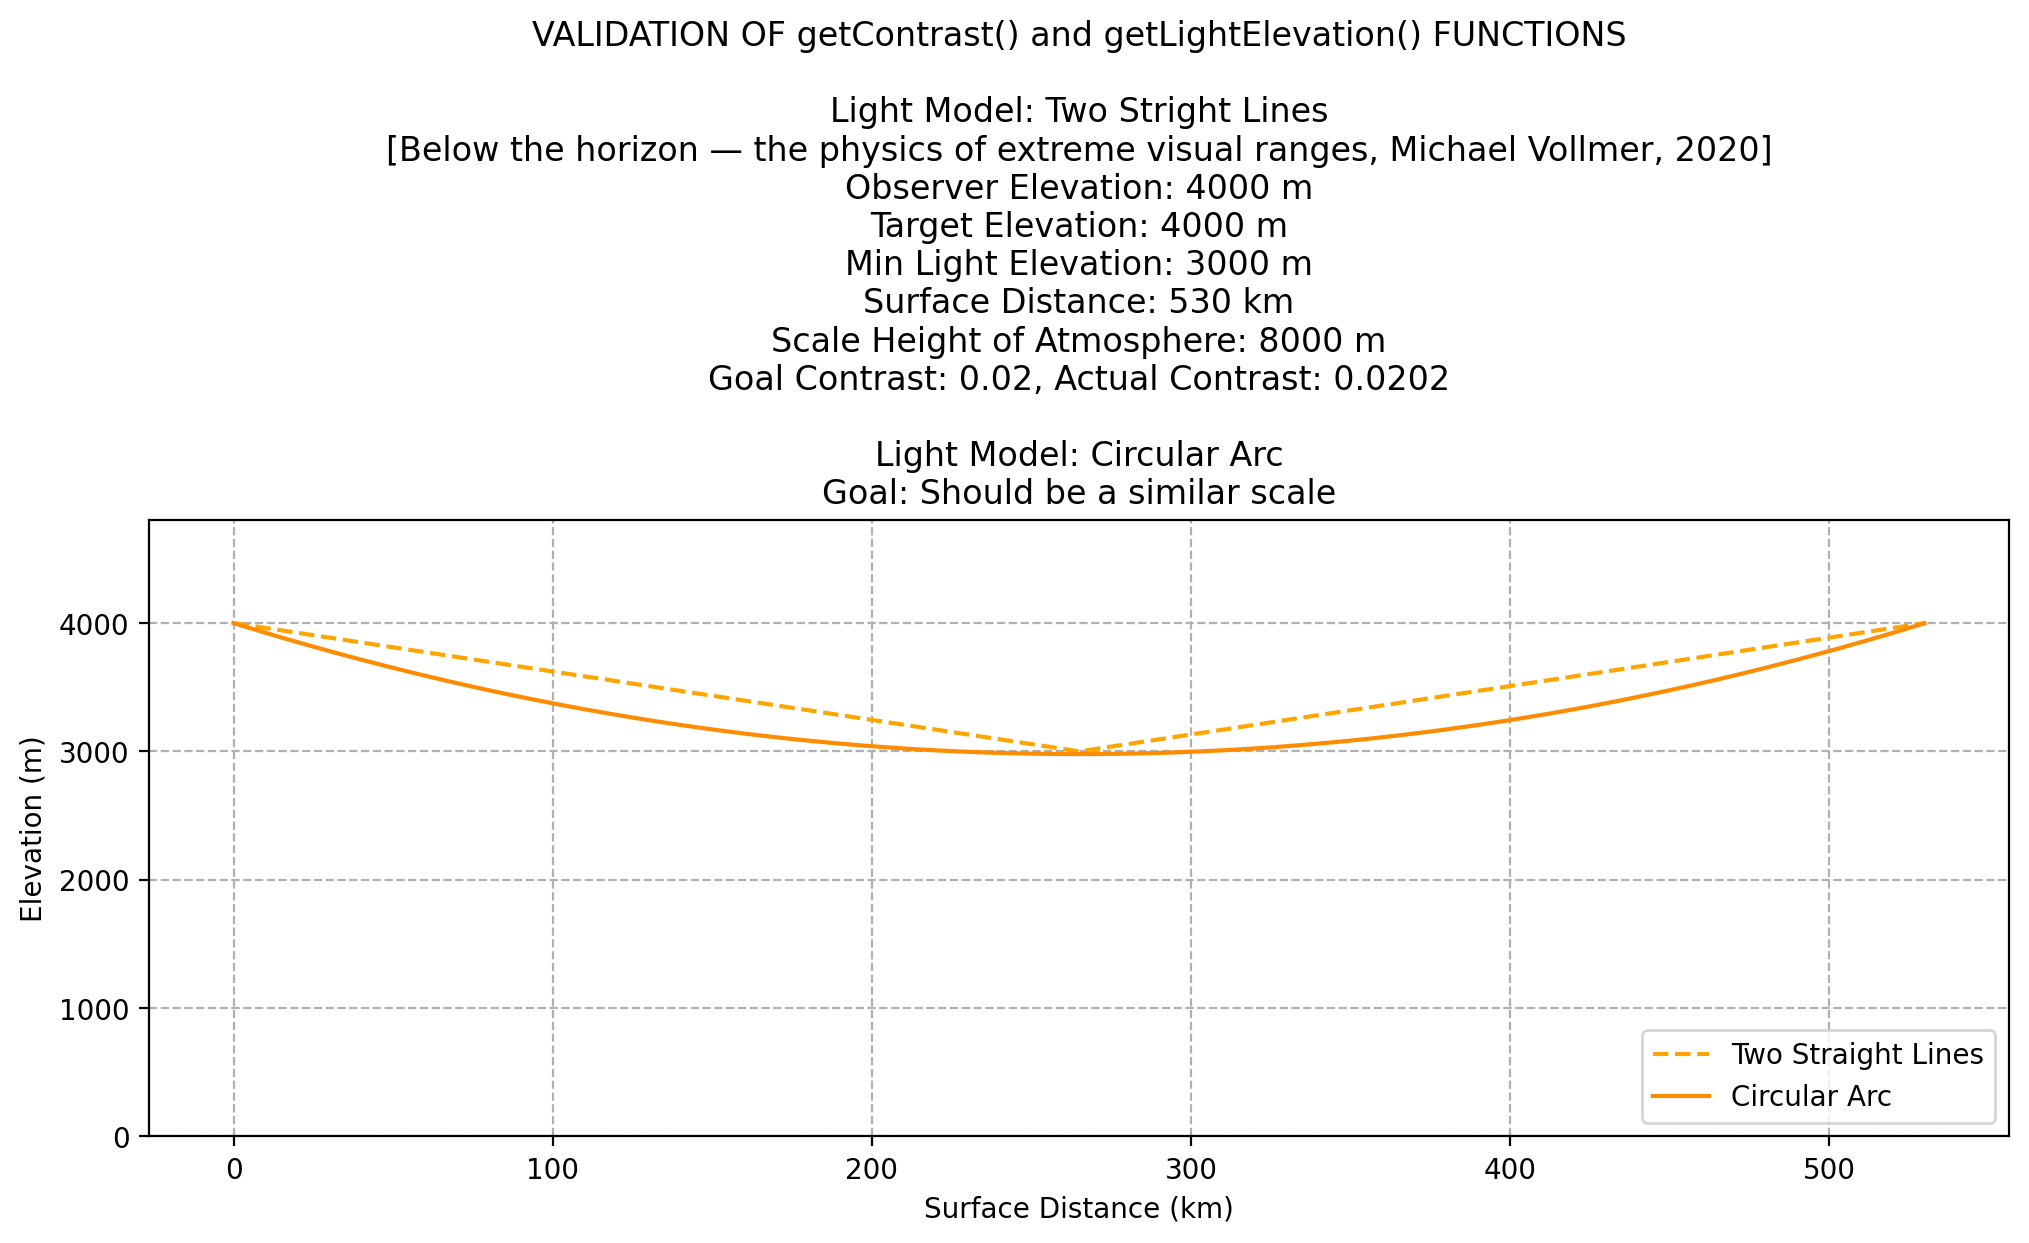

In [7]:
import math
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

B0 = 0.00001139
H_Straight = 8000
H = me.atmosphereScaleHeight

h1 = 4000
h2 = 4000
D = 530000
C = 6.4
R = me.earthRadius

def getLightElevation(x, h1, h2, D, C, R):
    delta_h = h2 - h1
    d = math.sqrt(D**2 + delta_h**2)
    r = (C - 1)*R
    T = math.sqrt(r**2 - (d**2)/4)
    
    x0 = D/2 - (delta_h/d)*T
    y0 = (h1 + h2)/2 + (D/d)*T

    y = y0 - math.sqrt(r**2 - (x - x0)**2)
    return y
    
def getLightElevationStraight(x, h1, h2, D, C, R):
    mid = 3000
    mid_x = D/2
    
    if x <= mid_x:
        return h1 + (mid-h1)*(x/mid_x)
    else:
        return mid + (h2-mid)*((x-mid_x)/mid_x)

def getScatterCoef(h, H):
    return B0 * math.exp(-h/H)

X = np.arange(0, D, 100)
Y_Straight = [getLightElevationStraight(x, h1, h2, D, C, R) for x in X]

resultStraight, error = quad(lambda x: getScatterCoef(getLightElevationStraight(x, h1, h2, D, C, R), H_Straight), 0, D)

B_avg_Straight = resultStraight/D

contrastStraight = math.exp(-B_avg_Straight*D)
contrastStraight

Y = [getLightElevation(x, h1, h2, D, C, R) for x in X]

result, error = quad(lambda x: getScatterCoef(getLightElevation(x, h1, h2, D, C, R), H), 0, D)

B_avg = result/D

contrast = math.exp(-B_avg*D)

plt.figure(figsize=(12, 4), facecolor="white", dpi=200)

plt.plot(X/1000, Y_Straight, c="orange", ls="--", label="Two Straight Lines")
plt.plot(X/1000, Y, c="darkorange", label="Circular Arc")

plt.ylim(bottom=0, top=max(Y)*1.2)

plt.xlabel("Surface Distance (km)")
plt.ylabel("Elevation (m)")
plt.title(f"VALIDATION OF getContrast() and getLightElevation() FUNCTIONS\n\n"

          "Light Model: Two Stright Lines\n" + 
          "[Below the horizon — the physics of extreme visual ranges, Michael Vollmer, 2020]\n" +
          "Observer Elevation: 4000 m\n" + 
          "Target Elevation: 4000 m\n" + 
          "Min Light Elevation: 3000 m\n" + 
          "Surface Distance: 530 km\n" + 
          "Scale Height of Atmosphere: 8000 m\n" + 
          f"Goal Contrast: 0.02, Actual Contrast: {round(contrastStraight, 4)}\n\n" + 
          
          f"Light Model: Circular Arc\n" + 
          "Goal: Should be a similar scale")

plt.grid(True, ls="--", zorder=0)

ax = plt.gca()
ax.set_facecolor("white")
plt.legend(loc = 4)

plt.savefig("../misc/images/scatter_validation", bbox_inches="tight")
plt.show()

In [9]:
testB0 = me.defaultScatterCoef0

knownLos['scatter'] = None

while sum(knownLos.scatter.isna()) > 0:

    print(f'Test Coefficient: {round(testB0, 8)}')
    print(f'LOS Remaining: {sum(knownLos.scatter.isna())}\n')

    print('Contrasts:')

    missingScatterMask = knownLos.scatter.isna()

    for i in knownLos.index[missingScatterMask]:
        los = knownLos.loc[i]
    
        observer = me.Summit(latitude=los.from_latitude,
                             longitude=los.from_longitude,
                             elevation=los.from_elevation)

        target = me.Summit(latitude=los.to_latitude,
                           longitude=los.to_longitude,
                           elevation=los.to_elevation)
    
        lineOfSight = me.LineOfSight(observer, target, scatterCoef0=testB0)
        lineOfSight.processFullLineOfSight()

        print(round(lineOfSight.getContrast(), 5))
        if lineOfSight.hasContrast():
            knownLos.at[i, 'scatter'] = round(testB0, 1)

    testB0 -= 0.00000001

Test Coefficient: 1.139e-05
LOS Remaining: 34

Contrasts:
0.02734
0.03014
0.03175
0.03455
0.03731
0.03161
0.03213
0.03568
0.03953
0.07099
0.04878
0.05028
0.05677
0.06808
0.06395
0.08084
0.07464
0.06894
0.0871
0.09428
0.07347
0.07365
0.07432
0.15557
0.11581
0.14044
0.16067
0.16864
0.16535
0.22303
0.19
0.17821
0.40379
0.40379
